In [1]:
import time
notebook_start = time.time()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score

In [2]:
# Insure that all columns and rows are displayed 
pd.options.display.max_columns = None
#pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', None)

In [3]:
# download a dataset with a description of each column
feat_def = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')

accepted_df = pd.read_csv('data/accepted_loans.csv')
rejected_df = pd.read_csv('data/rejected_loans.csv')
accepted_df

,addr_state,annual_inc,application_type,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,id,initial_list_status,installment,int_rate,issue_d,loan_amnt,loan_status,mort_acc,open_acc,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,zip_code
0,OK,28500.0,Individual,30.27,Apr-1995,< 1 year,1st Nat'l Bank of Broken Arrow,734.0,730.0,A,OWN,1476655,f,232.34,7.90,2012-08-01,7425.0,1,0.0,8.0,0.0,0.0,major_purchase,19631.0,55.5,A4,36 months,Machine Loan,22.0,Source Verified,740xx
1,OH,55000.0,Individual,22.32,Nov-2002,10+ years,Chase,709.0,705.0,B,MORTGAGE,1466703,f,532.35,12.12,2012-08-01,16000.0,0,4.0,10.0,0.0,0.0,debt_consolidation,12173.0,66.5,B3,36 months,Debt consolidation,17.0,Not Verified,430xx
2,WA,40000.0,Individual,14.64,Apr-2006,4 years,State of Washington,689.0,685.0,B,MORTGAGE,1466945,f,226.11,13.11,2012-08-01,6700.0,1,3.0,11.0,0.0,0.0,debt_consolidation,7481.0,51.2,B4,36 months,Debt consolidation,15.0,Not Verified,991xx
3,GA,30000.0,Individual,34.92,Nov-2002,< 1 year,Pediatric Group,674.0,670.0,C,RENT,1470307,f,139.27,15.31,2012-08-01,4000.0,1,0.0,6.0,0.0,0.0,moving,2895.0,12.0,C2,36 months,Moving expenses,9.0,Verified,309xx
4,TX,96000.0,Individual,26.15,Aug-1996,< 1 year,Jordan Carriers,719.0,715.0,A,MORTGAGE,1479588,f,381.04,8.90,2012-08-01,12000.0,0,2.0,18.0,0.0,0.0,debt_consolidation,19303.0,37.1,A5,36 months,Debt Consolidation,39.0,Not Verified,773xx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,AZ,55000.0,Individual,10.15,Feb-2004,9 years,Building Maintenance,754.0,750.0,A,RENT,144706534,f,49.95,8.81,2018-12-01,1575.0,0,0.0,4.0,0.0,0.0,moving,5697.0,32.0,A5,36 months,Moving and relocation,12.0,Not Verified,856xx
99996,SC,105000.0,Individual,22.19,Jul-1987,10+ years,Financial Center Manager III,694.0,690.0,B,MORTGAGE,144912397,w,317.95,11.80,2018-12-01,9600.0,0,6.0,19.0,0.0,0.0,medical,48561.0,84.7,B4,36 months,Medical expenses,28.0,Not Verified,297xx
99997,CA,40000.0,Individual,17.85,Mar-2013,5 years,Customer Service Representative,669.0,665.0,C,RENT,144544575,w,35.61,16.91,2018-12-01,1000.0,0,0.0,8.0,0.0,0.0,home_improvement,13560.0,71.0,C5,36 months,Home improvement,10.0,Source Verified,902xx
99998,TX,62000.0,Individual,22.90,Aug-2000,4 years,Maintenance Technician,764.0,760.0,A,MORTGAGE,145007684,w,251.40,8.19,2018-12-01,8000.0,0,2.0,8.0,0.0,0.0,debt_consolidation,8212.0,43.9,A4,36 months,Debt consolidation,32.0,Not Verified,763xx


## More cleaning

In [4]:
# drop the rows from the definition dataframe with definitions of columns we dropped
for i in feat_def.index:
    if feat_def.LoanStatNew[i] not in accepted_df.columns:
        feat_def.drop(i, inplace=True)
print(feat_def.shape)
accepted_df.shape

(31, 2)


(100000, 31)

In [5]:
feat_def

,LoanStatNew,Description
2,addr_state,The state provided by the borrower in the loan application
4,annual_inc,The self-reported annual income provided by the borrower during registration.
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
18,earliest_cr_line,The month the borrower's earliest reported credit line was opened
19,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
20,emp_title,The job title supplied by the Borrower when applying for the loan.*
21,fico_range_high,The upper boundary range the borrower’s FICO at loan origination belongs to.
22,fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.
25,grade,LC assigned loan grade


Some of these features will not be relevant, such as:
* id
* emp_title
* addr_state
* title



In [6]:
irrelavant_cols= ['id','emp_title','addr_state', 'title']
accepted_df.drop(irrelavant_cols, axis=1, inplace=True)

We need to remove the muticollinearity from the dataset. With this many features about a loan application there are probably a lot of features that are co-llinear. The problem with these feature is that even if one variable can be useful for the predicting the class, it is possible that the model can figure out the class by using the many other features, so we can drop those columns. Leaving in every feature can lead the model to overfit on the trainig data. As well as weaken interpretability.

I'll use the "Variance Inflation Factors" tool from statsmodels to find the collinear features.

In [7]:
# seperate the dataframe to numerical and categorical features.
num_feat = accepted_df.select_dtypes(include=['float64', 'int64']).copy()
cat_feat = accepted_df.select_dtypes(include='object').copy()
print('There are', num_feat.shape[1], 'numerical features, and', cat_feat.shape[1], 'categorical features.')

There are 15 numerical features, and 12 categorical features.


In [8]:
# define a function to calculate the vif score for each feature and sort them by score and them plot them out.
def calc_plot_vif(X):

    # Calculating VIF
    vif_df = pd.DataFrame()
    vif_df["variables"] = X.columns
    vif_df["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    # Sort them by vif scores
    vif_df.sort_values('vif', ascending=False, inplace=True)
    
    # display a bar plot of the highest 20 scores
    x = vif_df[vif_df.vif > 5].variables
    y = vif_df[vif_df.vif > 5].vif
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.bar(np.arange(len(x)),y, log=1)
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x, rotation=90, zorder=100)
    fig.show()
    
    return(vif_df.reset_index(drop=True))

<ipython-input-8-ad733c38e3bd>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,variables,vif
0,fico_range_high,3.210446e+07
1,fico_range_low,3.207437e+07
2,loan_amnt,4.227904e+01
3,installment,4.085933e+01
4,total_acc,1.289984e+01
5,open_acc,1.262254e+01
6,int_rate,1.255972e+01
7,revol_util,9.023542e+00
8,dti,6.153523e+00
9,annual_inc,3.237450e+00


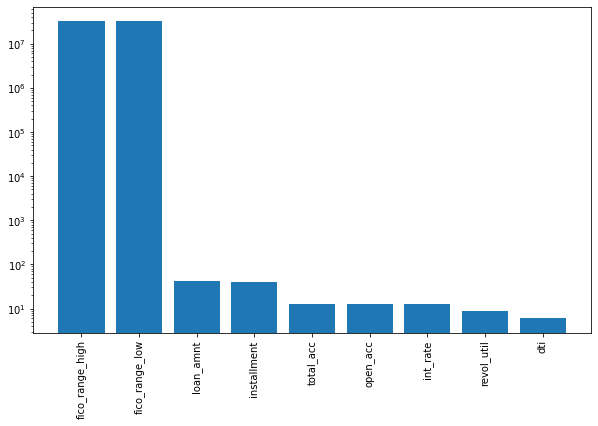

In [9]:
vif_df = calc_plot_vif(num_feat)
vif_df

The bar graph shows the features that have a high vif score.

Dropping columns with high scores, should bring down the other columns scores as well. For the fico_range columns, I'll create a new feature as the mean between the two and drop the originals. I'll drop open_acc since that must be correlated with total_acc, I'll drop installment since that is probably correlated with the loan amnt, as well as revol_util since I don't believe it's very important. And see how that effects the other scores.

<ipython-input-8-ad733c38e3bd>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,variables,vif
0,mean_fico_range,16.326683
1,int_rate,10.247295
2,total_acc,6.891467
3,dti,5.850643
4,loan_amnt,5.225346
5,annual_inc,3.221277
6,loan_status,2.252680
7,mort_acc,2.063246
8,revol_bal,2.033540
9,pub_rec_bankruptcies,1.916937


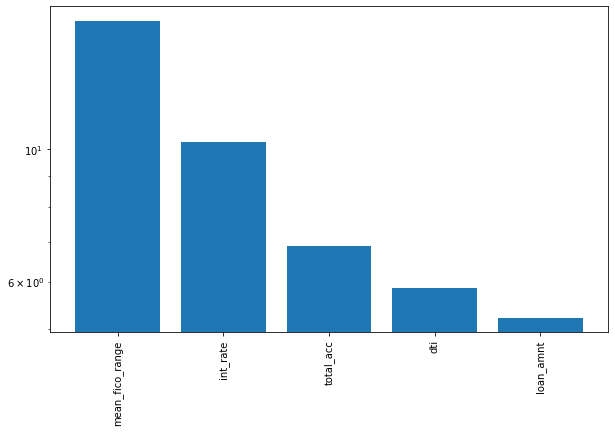

In [10]:
# create new column from the two fico ranges
num_feat['mean_fico_range'] = 0.5*num_feat.fico_range_high + 0.5*num_feat.fico_range_low
# drop high vif columns
num_feat.drop(['fico_range_high', 'fico_range_low', 'open_acc', 'installment', 'revol_util'], axis=1, inplace=True)
# calculate vif scores again 
vif_df1 = calc_plot_vif(num_feat)
vif_df1

We can take a look at how correlated these variables are with the target.

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


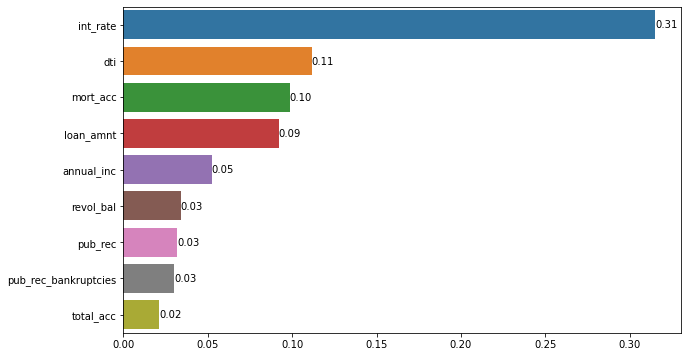

In [11]:
cor_tar = num_feat.iloc[:, :-1].corrwith(num_feat['loan_status']).abs().sort_values(ascending=False)[1:]
plt.figure(figsize=(10,6))
bar = sns.barplot(cor_tar, cor_tar.index, )
for p in bar.patches:
    width = p.get_width()    # get bar length
    bar.text(width,  # set the text at bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

I think you can't use pearsons correlation for a continuous variable to a binary categorical variable, so I'm not sure if this is very useful...

We are now very close to having all the numerical features under the vif-score of 5. I believe we can go on with these features, and later I will try feature elimination function, or PCA and that should take care of the rest.

Now we can have a look at the categorical features.

In [12]:
cat_feat

,application_type,earliest_cr_line,emp_length,grade,home_ownership,initial_list_status,issue_d,purpose,sub_grade,term,verification_status,zip_code
0,Individual,Apr-1995,< 1 year,A,OWN,f,2012-08-01,major_purchase,A4,36 months,Source Verified,740xx
1,Individual,Nov-2002,10+ years,B,MORTGAGE,f,2012-08-01,debt_consolidation,B3,36 months,Not Verified,430xx
2,Individual,Apr-2006,4 years,B,MORTGAGE,f,2012-08-01,debt_consolidation,B4,36 months,Not Verified,991xx
3,Individual,Nov-2002,< 1 year,C,RENT,f,2012-08-01,moving,C2,36 months,Verified,309xx
4,Individual,Aug-1996,< 1 year,A,MORTGAGE,f,2012-08-01,debt_consolidation,A5,36 months,Not Verified,773xx
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Individual,Feb-2004,9 years,A,RENT,f,2018-12-01,moving,A5,36 months,Not Verified,856xx
99996,Individual,Jul-1987,10+ years,B,MORTGAGE,w,2018-12-01,medical,B4,36 months,Not Verified,297xx
99997,Individual,Mar-2013,5 years,C,RENT,w,2018-12-01,home_improvement,C5,36 months,Source Verified,902xx
99998,Individual,Aug-2000,4 years,A,MORTGAGE,w,2018-12-01,debt_consolidation,A4,36 months,Not Verified,763xx


In [13]:
cat_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   application_type     100000 non-null  object
 1   earliest_cr_line     100000 non-null  object
 2   emp_length           100000 non-null  object
 3   grade                100000 non-null  object
 4   home_ownership       100000 non-null  object
 5   initial_list_status  100000 non-null  object
 6   issue_d              100000 non-null  object
 7   purpose              100000 non-null  object
 8   sub_grade            100000 non-null  object
 9   term                 100000 non-null  object
 10  verification_status  100000 non-null  object
 11  zip_code             100000 non-null  object
dtypes: object(12)
memory usage: 9.2+ MB


In [14]:
# description of the categorical features
feat_def[feat_def.LoanStatNew.isin(cat_feat.columns)]

,LoanStatNew,Description
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
18,earliest_cr_line,The month the borrower's earliest reported credit line was opened
19,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
25,grade,LC assigned loan grade
26,home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"
29,initial_list_status,"The initial listing status of the loan. Possible values are – W, F"
35,issue_d,The month which the loan was funded
87,purpose,A category provided by the borrower for the loan request.
92,sub_grade,LC assigned loan subgrade
94,term,The number of payments on the loan. Values are in months and can be either 36 or 60.


I don't think I will need the earliest_cr_line feature, So I will drop it.

We need to get all these variables to numerical so I can run a logistic regression on them. We can use One Hot Encoding for this. this will make each unique value in every column a new feature. 

From the descriptions we know that many of these are binary, like : application type, initial listing status, term and verification status. So those won't add to the number of features.
Home ownership has 4 unique values, grade has 7, employment length and purpose should have around 10.

But the zipcode and issue date are going to have a very large number of unique values, so this will make the dataframe very sparse. The issue date is by month, so I can check if there different amounts of loans were given out based on month, to see if I can drop that.

<ipython-input-15-2681400daa71>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


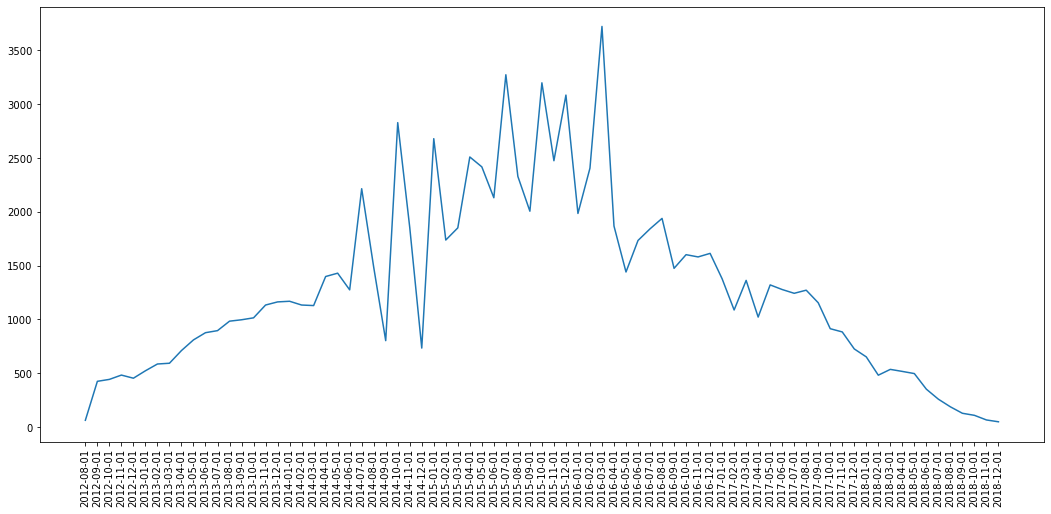

In [15]:
x = cat_feat.groupby('issue_d').count().application_type.index
y = cat_feat.groupby('issue_d').count().application_type.values
fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation=90, zorder=100)
fig.show()

This plot shows that there were a lot more loans given out from mid 2014 to 2016, but there isn't any monthly trend. So I will drop the date column. As for zipcode, I plan on investigating the the demographics of the zip_codes that had higher or lower rates of defaults, so for now I will drop it but I will revisit this feature later. 

The features that have binary columns I will just convert to a 1 or 0 manually, so that I know which 1 is which value. I will also do the emp_length manually. I will use get dummies for purpose, for the other features I will use a label encoder.

In [16]:
cat_feat.emp_length.value_counts()

10+ years    34674
2 years       9686
3 years       8667
< 1 year      8615
1 year        6974
4 years       6432
5 years       6397
6 years       4884
8 years       4883
7 years       4659
9 years       4129
Name: emp_length, dtype: int64

In [17]:
cat_feat.verification_status.value_counts()

Source Verified    42883
Verified           30343
Not Verified       26774
Name: verification_status, dtype: int64

In [18]:
emp_length_to_int={'< 1 year':0,
                      '1 year':1,
                     '2 years':2,
                     '3 years':3,
                     '4 years':4,
                     '5 years':5,
                     '6 years':6,
                     '7 years':7,
                     '8 years':8,
                     '9 years':9,
                     '10+ years':10}
cat_feat['emp_length'] = cat_feat['emp_length'].map(emp_length_to_int)
cat_feat['application_type'] = cat_feat['application_type'].map({'Individual': 0, 'Joint App': 1})
cat_feat['term'] = cat_feat['term'].map({' 36 months': 0, ' 60 months': 1})
le = LabelEncoder()
cat_feat['grade'] = le.fit_transform(cat_feat['grade'])
cat_feat['verification_status'] = le.fit_transform(cat_feat['verification_status'])
cat_feat['sub_grade'] = le.fit_transform(cat_feat['sub_grade'])
cat_feat['home_ownership'] = le.fit_transform(cat_feat['home_ownership'])
cat_feat['emp_length'] = le.fit_transform(cat_feat['emp_length'])
cat_feat.drop(['issue_d', 'earliest_cr_line', 'zip_code', 'purpose'], axis=1, inplace=True)
# cat_feat = pd.get_dummies(cat_feat, columns=['purpose'], drop_first=False)
cat_feat

,application_type,emp_length,grade,home_ownership,initial_list_status,sub_grade,term,verification_status
0,0,0,0,4,f,3,0,1
1,0,10,1,1,f,7,0,0
2,0,4,1,1,f,8,0,0
3,0,0,2,5,f,11,0,2
4,0,0,0,1,f,4,0,0
...,...,...,...,...,...,...,...,...
99995,0,9,0,5,f,4,0,0
99996,0,10,1,1,w,8,0,0
99997,0,5,2,5,w,14,0,1
99998,0,4,0,1,w,3,0,0


Now we put the two dataframes back together so we can run a model on it.

In [19]:
df = pd.concat([num_feat, cat_feat], axis=1)
df.shape

(100000, 19)

I will eventually run a PCA on this dataset, since with this many features there is bound to be overfitting. For now though I will keep the features intact so I can get some more understanding of which features are important.

In [20]:
# split testing and training data
X = df.drop('loan_status', axis=1)
y= df.loan_status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

We need to scale the numerical features before running the logistic regression. I waited till the numerical and categorical features were put back together because I needed to make the train test split first to aviod data-leakage. Now I need to seperate the numerical features again to do the standard scaling, and then put them back together.

In [21]:
# get list of numerical columns and remove loan status
nums = list(num_feat.columns)
nums.remove('loan_status')

# seperate the numerical columns for the training and testing data
train_num = X_train[nums]
test_num = X_test[nums]

# instnatiate standard scaler fit on training data and transform on both
minmax = MinMaxScaler()
train_num_scaled = pd.DataFrame(minmax.fit_transform(train_num))
test_num_scaled = pd.DataFrame(minmax.transform(test_num))

# renane the columns back to the previous names
train_num_scaled.columns = nums
test_num_scaled.columns = nums

# Put the dataframes back together
# reset the categorical features index for the concatenation
train_cat = X_train.drop(nums, axis=1).reset_index()
test_cat = X_test.drop(nums, axis=1).reset_index()
X_train_sc = pd.concat([train_num_scaled, train_cat], axis=1)
X_test_sc = pd.concat([test_num_scaled, test_cat], axis=1)

We can finaly put this through a logistic regression. First I'll run a dummy classifier as my baseline to compare, then I'll run a simple model with the way the data is now, and I'll continue to explore different options afterwards.

0.49933333333333335

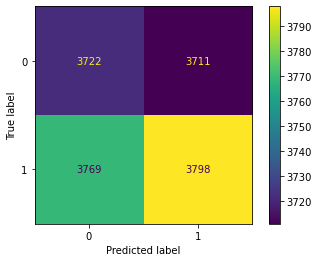

In [22]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train_sc, y_train)
plot_confusion_matrix(dummy, X_test_sc, y_test)
dummy.score(X_test_sc, y_test)

In [23]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_iter': [75, 100, 125, 200, 500],
    'C': [0.01, 0.1, 1, 10]
    }
    
    # Instantiate & fit LogReg model for GridSearch
    # set the solver to newton-cg because I get line did not converge warnings otherwise
    grid_logreg = LogisticRegression(solver='newton-cg',random_state=42)
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv, scoring='recall')
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    f1 = f1_score(y_test, y_pred)
    print(f'F1 Score: {f1}')
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)

In [24]:
logreg(X_train_sc, X_test_sc, y_train, y_test)

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1342, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packa

ValueError: could not convert string to float: 'w'

In [ ]:
notebook_end = time.time()
print(f'This notebook takes {round(notebook_end - notebook_start, 0)} seconds to run')